In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split#, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders import OneHotEncoder
import ipywidgets

# how to become a superhost:
# https://www.airbnb.com/help/article/829/how-do-i-become-a-       

In [224]:
filepath = 'Data/listings.csv.gz'

def wrangle(filepath):
    air = pd.read_csv(filepath, index_col='id')

    # Dropping columns with too many null values
    drop_cols_null = ['neighbourhood_group_cleansed', 'bathrooms',
                     'calendar_updated']
    # air.isnull().sum()
    air.drop(columns=drop_cols_null, inplace=True)
    
    # Dropping columns that seem irrelevant URL links
    drop_cols = ['listing_url', 'scrape_id', 'picture_url', 'description',
                 'neighborhood_overview', 'host_url', 'host_location', 'name',
                 'host_name', 'host_about', 'host_thumbnail_url',
                 'host_picture_url', 'host_neighbourhood', 'neighbourhood',
                 'host_total_listings_count',
                 'last_scraped']

    # Seem irrelevant/ noise for our data
    drop_cols2 = ['minimum_nights', 'maximum_nights',
                  'minimum_minimum_nights', 'maximum_minimum_nights',
                   'minimum_maximum_nights', 'maximum_maximum_nights',
                   'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
                   'availability_30', 'availability_60', 'availability_90',
                   'availability_365', 'calendar_last_scraped',
                   'calculated_host_listings_count',
                   'calculated_host_listings_count_entire_homes',
                   'calculated_host_listings_count_private_rooms',
                   'calculated_host_listings_count_shared_rooms',
                   'review_scores_accuracy',
                   'review_scores_cleanliness', 'review_scores_checkin',
                   'review_scores_communication', 'review_scores_location',
                   'review_scores_value', 'license', 'number_of_reviews_ltm',
                   'number_of_reviews_l30d', 'first_review', 'last_review', 'host_acceptance_rate',
                   'reviews_per_month',
                   'host_response_time', 'host_response_rate', 'host_since']
    air.drop(columns=drop_cols, inplace=True)
    air.drop(columns=drop_cols2, inplace=True)
    
    #fix this later
    air.drop(columns=['bathrooms_text', 'neighbourhood_cleansed','room_type'], inplace=True)
   

    # Change the columns t (true) and f (false) to 0 and 1's
    ### note, change type
    
    # Dropping the host_id
    
    air['latitude'] = air.latitude

    air.loc[air['host_identity_verified'] == "t", 'host_identity_verified'] = 1
    air.loc[air['host_identity_verified'] == "f", 'host_identity_verified'] = 0

    air.loc[air['host_has_profile_pic'] == "t", 'host_has_profile_pic'] = 1
    air.loc[air['host_has_profile_pic'] == "f", 'host_has_profile_pic'] = 0

    air.loc[air['instant_bookable'] == "t", 'instant_bookable'] = 1
    air.loc[air['instant_bookable'] == "f", 'instant_bookable'] = 0

    air['super_host'] = 1
    air.loc[air['host_is_superhost'] == 'f', 'super_host'] = 0
    air.drop(columns='host_is_superhost', inplace=True)

    # cleaning the price column to be integers
    air['price'] = air['price'].str.replace(',', '').str.strip('$').astype(float)

    #if we have time we can review this items:
    cols_stretch_goal = ['host_verifications', 'amenities', 'property_type']
    air.drop(columns=cols_stretch_goal, inplace=True)
    
    to_numeric = ['host_identity_verified', 'host_has_profile_pic', 'instant_bookable']
    air[to_numeric] = air[to_numeric].apply(pd.to_numeric, downcast='float')

    air.head(20)
    # Let's rename the columns
#     air.columns = ['host_id', 'listing_count', 'profile_pic', 'id_verified',
#                   'ward', 'lat', 'long', 'room_type', 'guest_count', 'bath',
#                   'bedroom', 'beds', 'price', 'review_count', 'review_score',
#                   'ins_book', 'super_host']
    
    return air

In [225]:
air = wrangle(filepath)
# air.head(5)

In [176]:
# air.bathrooms_text.value_counts()

In [50]:
# for future reference: data for the station's locations
# https://ckan-tokyochallenge.odpt.org/en/dataset?tags=列車ロケーション情報-train_location_information


In [226]:
target='price'
X = air.drop(columns=target)
y = air[target]

# Let's split into a test and
X_train, X_t, y_train, y_t = train_test_split(X,y, test_size=.2, random_state=7)

# Let's split our test data into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_t,y_t, test_size=.2, random_state=7)

print('Training:', len(X_train))
print('Validation:', len(X_val))
print('Test:', len(X_test))

Training: 8957
Validation: 1792
Test: 448


In [227]:
# Random forest regression

model_rf = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=70))
model_rf.fit(X_train,y_train);


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [228]:
# Mean Absolute Error Accuracy Score
# Training
print('Random Forest Regressor')

y_pred = len(y_train) *[y_train.mean()]
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE: ', baseline_mae)

training_acc = mean_absolute_error(y_train,model_rf.predict(X_train))
print('MAE Train: ', training_acc)

# Validation
val_acc = mean_absolute_error(y_val,model_rf.predict(X_val))
print('MAE Validation: ',val_acc)

# R squared
print('Rsquared Validation:', r2_score(y_val, model_rf.predict(X_val)))

Random Forest Regressor
Baseline MAE:  9628.7062014588
MAE Train:  2687.8105226899775
MAE Validation:  6527.5684512272355
Rsquared Validation: 0.40135804091136007


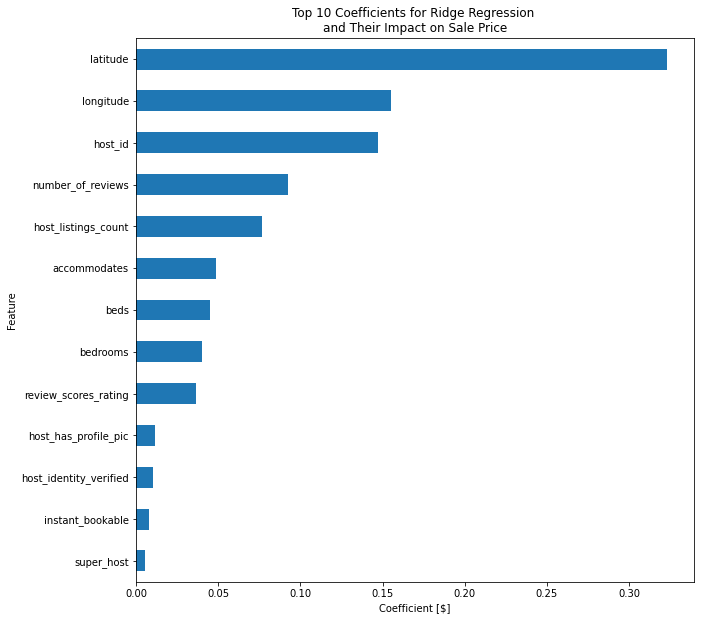

In [229]:
# Create bar chart
# Add coefficients from Model_r's named steps
coefficients = model_rf.named_steps['randomforestregressor'].feature_importances_

# Add feature names from Model_r's named steps
features = model_rf.named_steps['onehotencoder'].get_feature_names()

# Combine the two values into a single object, sorting based on the absolute value
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

# Create the bar chart and limit it to the top 10 features

fig, ax = plt.subplots(figsize=(10, 10))
feat_imp.plot(kind='barh')
# Add labels to the chart
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Top 10 Coefficients for Ridge Regression \nand Their Impact on Sale Price')
plt.show();

In [232]:
# df_feature_importances = pd.DataFrame(model.named_steps['randomorestregressor'].feature_importances_*100,columns=["Importance"],index=col_names)
# df_feature_importances = df_feature_importances.sort_values("Importance", ascending=True)

In [231]:
# print(feat_imp)

In [233]:
air.to_csv('clean_data.csv')

In [234]:
clean_data = pd.read_csv('clean_data.csv')
clean_data.columns

Index(['id', 'host_id', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'price', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'super_host'],
      dtype='object')

In [215]:
# feat_imp.index

In [235]:
# #top3 - latitude, longitude, host_id, number_of_reviews, accomodates, 

# top_list = ['latitude', 'longitude', 'accommodates']

# for item in top_list:
#     print(item)
#     minimum = air[item].min()
#     maximum = air[item].max()
#     print('Min', minimum)
#     print('Max', maximum)
#     print('Difference', (maximum-minimum)/10)
    
#     print(' ')

Training: 8957
Validation: 1792
Test: 448


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Random Forest Regressor
Rsquared Validation: 0.012445462337617896


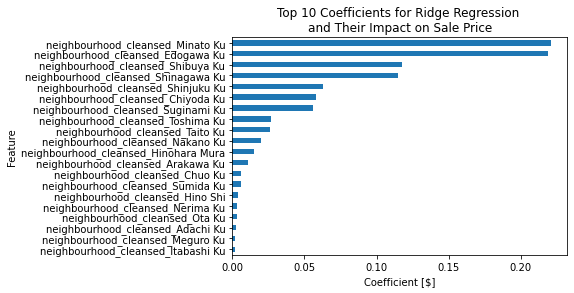

In [141]:
# ## checking for wards of Tokyo
# target='price'
# X = air.drop(columns=target)
# X = air['neighbourhood_cleansed']
# y = air[target]

# # Let's split into a test and
# X_train, X_t, y_train, y_t = train_test_split(X,y, test_size=.2, random_state=7)

# # Let's split our test data into validation and test
# X_val, X_test, y_val, y_test = train_test_split(X_t,y_t, test_size=.2, random_state=7)

# print('Training:', len(X_train))
# print('Validation:', len(X_val))
# print('Test:', len(X_test))


# model_rf = make_pipeline(OneHotEncoder(use_cat_names=True),
#                          SimpleImputer(),
#                          RandomForestRegressor(random_state=70))
# model_rf.fit(X_train,y_train);

# #######

# # Mean Absolute Error Accuracy Score
# # Training
# print('Random Forest Regressor')

# y_pred = len(y_train) *['Shinjuku Ku']
# # baseline_mae = mean_absolute_error(y_train, y_pred)
# # print('Baseline MAE: ', baseline_mae)

# # training_acc = mean_absolute_error(y_train, model_rf.predict(X_train))
# # print('MAE Train: ', training_acc)

# # # Validation
# # val_acc = mean_absolute_error(y_val, model_rf.predict(X_val))
# # print('MAE Validation: ',val_acc)

# # R squared
# print('Rsquared Validation:', r2_score(y_val, model_rf.predict(X_val)))

# #######

# # Create bar chart
# # Add coefficients from Model_r's named steps
# coefficients = model_rf.named_steps['randomforestregressor'].feature_importances_

# # Add feature names from Model_r's named steps
# features = model_rf.named_steps['onehotencoder'].get_feature_names()

# # Combine the two values into a single object, sorting based on the absolute value
# feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

# # feat_importances = pd.DataFrame(coefficients, columns)

# # Create the bar chart and limit it to the top 10 features
# feat_imp.tail(20).plot(kind='barh')
# # Add labels to the chart
# plt.xlabel('Coefficient [$]')
# plt.ylabel('Feature')
# plt.title('Top 10 Coefficients for Ridge Regression \nand Their Impact on Sale Price')
# plt.show();

In [265]:
features

['host_id',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'number_of_reviews',
 'review_scores_rating',
 'instant_bookable',
 'super_host']

In [218]:
# air['neighbourhood_cleansed'].value_counts().index

In [ ]:
model_rf.predict()

In [112]:
import pickle

In [277]:
my_model = pickle.dumps(model_rf)

In [281]:
outfile = open('random_forest_model', 'wb')
pickle.dump(model_rf, outfile)

In [272]:
X1 = air.latitude.mean()
X2 = air.longitude.mean()
X3 = air.accommodates.mean()

df = X_train
input_X = np.array([258668827,
                    1,
                    1,
                    1,
                    X1,
                    X2,
                    X3,
                    df["bedrooms"].mean(),
                    df['beds'].mean(),
                    df['number_of_reviews'].mean(),
                    df["review_scores_rating"].mean(),
                    1,
                    1]).reshape(1, -1)

# input_X
# ['host_id',
#  'host_listings_count',
#  'host_has_profile_pic',
#  'host_identity_verified',
#  'latitude',
#  'longitude',
#  'accommodates',
#  'bedrooms',
#  'beds',
#  'number_of_reviews',
#  'review_scores_rating',
#  'instant_bookable',
#  'super_host']


In [274]:
prediction = model_rf.named_steps['randomforestregressor'].predict(input_X)

In [276]:
prediction[0]

11424.47